In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import string
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F  

In [51]:
# Hyperparameters
embed_dim = 64
hidden_dim = 64
seq_len = 16 # Input and reconstruction lenght
optimized_len = 128 # Optimized text lenght
num_epochs = 1
train_rows = 1  # Number of articles of the BBC data to train on
test_rows = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Obfuscator(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, embed_dim, hidden_dim, input_len, output_length):
        super(Obfuscator, self).__init__()
        self.embedding = nn.Embedding(input_vocab_size, embed_dim)
        self.encoder = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.decoder = nn.GRU(hidden_dim, embed_dim, batch_first=True)
        self.projection_out_vocab = nn.Linear(embed_dim, output_vocab_size)
        self.projection_out_len = nn.Linear(input_len, output_length)
        self.output_vocab_size = output_vocab_size
        
    def forward(self, x):
        # x.shape: batch_size, seq_len
        # embedded.shape: batch_size, seq_len, embed_dim
        embedded = self.embedding(x)
        # encoded_output.shape: batch_size, seq_len, hidden_dim
        encoded_output, _ = self.encoder(embedded)
        
        # decoded_output.shape: batch_size, seq_len, embed_dim
        decoded_output, _ = self.decoder(encoded_output)
        
        # decoded_output.shape: batch_size, seq_len, intermediate_vocab_size
        projected_out_vocab_size = self.projection_out_vocab(decoded_output)
        
        # decoded_output.shape: batch_size, intermediate_seq_len, vocab_size
        projected_out_len = self.projection_out_len(projected_out_vocab_size.transpose(1, 2)).transpose(1, 2)
        # decoded_output.shape: batch_size, intermediate_seq_len, vocab_size
        logits = projected_out_len
        
        return logits

In [ ]:
class Deobfuscator(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, embed_dim, hidden_dim, input_len, output_length):
        super(Deobfuscator, self).__init__()
        self.embedding = nn.Linear(input_vocab_size, embed_dim)
        self.encoder = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.decoder = nn.GRU(hidden_dim, embed_dim, batch_first=True)
        self.projection_out_vocab = nn.Linear(embed_dim, output_vocab_size)
        self.projection_out_len = nn.Linear(input_len, output_length)
        self.output_vocab_size = output_vocab_size        

    def forward(self, x):
        # x.shape: batch_size, intermediate_seq_len, intermediate_vocab_size
        # embedded.shape: batch_size, intermediate_seq_len, embed_dim
        embedded = self.embedding(x)
        # encoded_output.shape: batch_size, intermediate_seq_len, hidden_dim
        encoded_output, _ = self.encoder(embedded)
        
        # encoded_output.shape: batch_size, intermediate_seq_len, hidden_dim
        decoded_output, _ = self.decoder(encoded_output)
        
        # encoded_output.shape: batch_size, intermediate_seq_len, vocab_size
        projected_out_vocab_size = self.projection_out_vocab(decoded_output)
        
        # encoded_output.shape: batch_size, seq_len, vocab_size
        projected_out_len = self.projection_out_len(projected_out_vocab_size.transpose(1, 2)).transpose(1, 2)
        logits = projected_out_len
        return logits

In [54]:
class Tokenizer:
    def __init__(self, original_vocab=string.ascii_lowercase + ' ', intermediate_vocab=string.ascii_lowercase, pad_token='<PAD>'):
        self.original_vocab = original_vocab
        self.original_vocab_size = len(original_vocab)

        self.intermediate_chars = intermediate_vocab
        self.intermediate_vocab_size = len(intermediate_vocab)
        
        self.pad_token = pad_token
        self.pad_token_idx = self.original_vocab_size  # The next index after all regular characters
        
        # Mapping for original characters
        self.original_char_to_idx = {char: idx for idx, char in enumerate(self.original_vocab)}
        self.original_idx_to_char = {idx: char for char, idx in self.original_char_to_idx.items()}
        
        # Compressed characters
        self.intermediate_char_to_idx = {char: idx for idx, char in enumerate(self.intermediate_chars)}
        self.intermediate_idx_to_char = {idx: char for idx, char in self.intermediate_char_to_idx.items()}

        # Add the <PAD> token to the vocabulary
        self.original_char_to_idx[pad_token] = self.pad_token_idx
        self.original_idx_to_char[self.pad_token_idx] = self.pad_token
        self.original_vocab_size += 1  # Update vocab size to account for the <PAD> token

    def clean_text(self, text):
        """Removes characters not in the defined vocabulary (lowercase ASCII + space)."""
        return ''.join(char.lower() for char in text if char.lower() in self.original_vocab)

    def encode(self, text):
        """Convert text into token indices."""
        return [self.original_char_to_idx[char] for char in text if char in self.original_char_to_idx]

    def decode(self, indices):
        """Convert token indices back into text, with <PAD> tokens represented."""
        return ''.join(self.original_idx_to_char[idx] if idx != self.pad_token_idx else '<PAD>' for idx in indices)

    def create_word_dictionary(self, text):
        """Create a set of unique words from cleaned text."""
        cleaned_text = self.clean_text(text)
        words = cleaned_text.split()  # Split by spaces
        word_dict = {word: idx for idx, word in enumerate(set(words))}  # Create a dictionary of unique words
        return word_dict

# Example usage
tokenizer = Tokenizer()

In [ ]:
# First autoencoder: compression (input length: seq_length, output length: optimized_len)
encoder = Obfuscator(
    input_vocab_size=tokenizer.original_vocab_size,
    output_vocab_size=tokenizer.intermediate_vocab_size,  # All printable ASCII characters
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    input_len=seq_len,
    output_length=optimized_len
).to(device)

# Second autoencoder: decompression (input length: optimized_len, output length: seq_length)
decoder = Deobfuscator(
    input_vocab_size=tokenizer.intermediate_vocab_size,  # All printable ASCII characters
    output_vocab_size=tokenizer.original_vocab_size,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    input_len=optimized_len,
    output_length=seq_len
).to(device)


In [56]:
class TextDataset(Dataset):
    def __init__(self, seq_len=16, train_rows=100, test_rows=20, pad_token_idx=tokenizer.pad_token_idx):
        self.seq_len = seq_len
        self.pad_token_idx = pad_token_idx
        self.word_dict = {}

        # Generate random data for training and evaluation
        train_data, eval_data = self.generate_random_sequences(train_rows, test_rows)

        # Flatten the generated data into a single list of tokens for creating sequences
        flat_train_data = [token for sublist in train_data for token in sublist]
        flat_eval_data = [token for sublist in eval_data for token in sublist]

        # Create sequences from the tokenized data, ensuring no words are cut off
        self.train_sequences = self.create_sequences_without_word_cutoff(flat_train_data, self.seq_len)
        self.eval_sequences = self.create_sequences_without_word_cutoff(flat_eval_data, self.seq_len)

        # Generate progressive sequences for training and evaluation
        self.progressive_train_sequences = self.generate_progressive_sequences(self.train_sequences, self.seq_len)
        self.progressive_eval_sequences = self.generate_progressive_sequences(self.eval_sequences, self.seq_len)

        # Prepare PyTorch tensors for training and evaluation data
        self.train_data = [torch.tensor(seq, dtype=torch.long) for seq in self.progressive_train_sequences]
        self.eval_data = [torch.tensor(seq, dtype=torch.long) for seq in self.progressive_eval_sequences]

    def encode(self, text):
        """Encodes text to indices."""
        return [tokenizer.original_char_to_idx.get(char, self.pad_token_idx) for char in text]

    def generate_random_sequences(self, train_rows, test_rows):
        """Generate random sequences for training and evaluation datasets."""
        characters = list(tokenizer.original_char_to_idx.keys())
        train_data = []
        eval_data = []

        for _ in range(train_rows):
            random_text = ''.join(random.choices(characters, k=self.seq_len))
            train_data.append(self.encode(random_text))

        for _ in range(test_rows):
            random_text = ''.join(random.choices(characters, k=self.seq_len))
            eval_data.append(self.encode(random_text))

        return train_data, eval_data

    def create_sequences_without_word_cutoff(self, tokenized_text, seq_len):
        sequences = []
        current_sequence = []
        current_length = 0

        words = ''.join([tokenizer.original_idx_to_char[idx] for idx in tokenized_text]).split()

        for word in words:
            word_tokenized = self.encode(word) + [tokenizer.original_char_to_idx[' ']]
            word_length = len(word_tokenized)

            if current_length + word_length > seq_len:
                current_sequence += [self.pad_token_idx] * (seq_len - current_length)
                sequences.append(current_sequence)
                current_sequence = word_tokenized
                current_length = word_length
            else:
                current_sequence += word_tokenized
                current_length += word_length

        if current_sequence:
            current_sequence += [self.pad_token_idx] * (seq_len - current_length)
            sequences.append(current_sequence)

        return sequences

    def generate_progressive_sequences(self, sequences, max_len):
        progressive_sequences = []
        pad_value = self.pad_token_idx

        for sequence in sequences:
            pad_found = False
            for i in range(1, max_len + 1):
                if pad_found:
                    break
                padded_sequence = sequence[:i] + [pad_value] * (max_len - i)
                progressive_sequences.append(padded_sequence)
                if pad_value in padded_sequence[:i]:
                    pad_found = True

        return progressive_sequences

    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, index):
        return self.train_data[index]

    def get_eval_data(self):
        return self.eval_data

In [57]:
# Initialize the dataset with generated sequences
text_dataset = TextDataset(seq_len=seq_len, train_rows=train_rows, test_rows=test_rows)

# Create DataLoaders for training and evaluation
train_dataloader = DataLoader(text_dataset, batch_size=32, shuffle=True)
eval_dataloader = DataLoader(text_dataset.get_eval_data(), batch_size=32, shuffle=True)

# Define the loss function and optimizers
criterion = nn.CrossEntropyLoss()

In [ ]:

# Run training multiple times and save the losses for each run
num_runs = 1  # Number of times to repeat the training loop

for run in range(1, num_runs + 1):
    print(f"\n--- Starting Training Run {run} ---")
        
    # Re-initialize the optimizers
    # First autoencoder: compression (input length: seq_length, output length: optimized_len)
    encoder = Obfuscator(
        input_vocab_size=tokenizer.original_vocab_size,
        output_vocab_size=tokenizer.intermediate_vocab_size,  # All printable ASCII characters
        embed_dim=embed_dim,
        hidden_dim=hidden_dim,
        input_len=seq_len,
        output_length=optimized_len
    ).to(device)

    # Second autoencoder: decompression (input length: optimized_len, output length: seq_length)
    decoder = Deobfuscator(
        input_vocab_size=tokenizer.intermediate_vocab_size,  # All printable ASCII characters
        output_vocab_size=tokenizer.original_vocab_size,
        embed_dim=embed_dim,
        hidden_dim=hidden_dim,
        input_len=optimized_len,
        output_length=seq_len
    ).to(device)

    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)
    
    # Lists to store losses and accuracies for the current run
    train_losses = []
    eval_accuracies = []
    eval_one_hot_accuracies = []
    def train_model(encoder, decoder, train_dataloader, eval_dataloader, criterion, encoder_optimizer, decoder_optimizer, num_epochs=100):
        for epoch in range(num_epochs):
            total_train_loss = 0

            # Training loop
            encoder.train()
            decoder.train()
            for sequences in train_dataloader:
                sequences = sequences.to(device).long()

                # Compression and decompression steps
                compressed_sequences = encoder(sequences)
                if torch.rand(1).item() < 0.9:
                    compressed_indices = torch.argmax(compressed_sequences, dim=-1)
                    compressed_sequences = F.one_hot(compressed_indices, num_classes=encoder.output_vocab_size).float()

                reconstructed_sequences = decoder(compressed_sequences).transpose(1, 2)
                loss = criterion(reconstructed_sequences, sequences)

                # Optimization
                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=0.5)
                torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=0.5)
                encoder_optimizer.step()
                decoder_optimizer.step()

                total_train_loss += loss.item() * sequences.size(0)

            average_train_loss = total_train_loss / len(train_dataloader.dataset)
            train_losses.append(average_train_loss)

            # Validation accuracy calculation
            encoder.eval()
            decoder.eval()
            total_correct_eval = 0
            total_tokens_eval = 0
            total_correct_eval_one_hot = 0

            with torch.no_grad():
                for sequences in eval_dataloader:
                    sequences = sequences.to(device).long()
                    compressed_sequences = encoder(sequences)
                    reconstructed_sequences = decoder(compressed_sequences).transpose(1, 2)
                    predicted_tokens_eval = torch.argmax(reconstructed_sequences, dim=1)
                    total_correct_eval += (predicted_tokens_eval == sequences).sum().item()
                    total_tokens_eval += sequences.numel()

                    compressed_indices = torch.argmax(compressed_sequences, dim=-1)
                    compressed_one_hot = F.one_hot(compressed_indices, num_classes=encoder.output_vocab_size).float()
                    reconstructed_sequences_one_hot = decoder(compressed_one_hot).transpose(1, 2)
                    predicted_tokens_eval_one_hot = torch.argmax(reconstructed_sequences_one_hot, dim=1)
                    total_correct_eval_one_hot += (predicted_tokens_eval_one_hot == sequences).sum().item()

            eval_accuracy = total_correct_eval / total_tokens_eval
            eval_accuracies.append(eval_accuracy)
            eval_one_hot_accuracy = total_correct_eval_one_hot / total_tokens_eval
            eval_one_hot_accuracies.append(eval_one_hot_accuracy)

            print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {average_train_loss:.4f}, Validation Accuracy = {eval_accuracy:.4f}, One-Hot Validation Accuracy = {eval_one_hot_accuracy:.4f}")

        return train_losses, eval_accuracies, eval_one_hot_accuracies

    # Run the training model and save metrics
    train_losses, eval_accuracies, eval_one_hot_accuracies = train_model(encoder, decoder, train_dataloader, eval_dataloader, criterion, encoder_optimizer, decoder_optimizer, num_epochs)

    # # Save each run's metrics with unique filenames
    # np.save(f"/kaggle/working/train_losses_run_128_9_{run}.npy", np.array(train_losses))
    # np.save(f"/kaggle/working/eval_accuracies_run_128_9_{run}.npy", np.array(eval_accuracies))
    # np.save(f"/kaggle/working/eval_one_hot_accuracies_run_128_9_{run}.npy", np.array(eval_one_hot_accuracies))

    print(f"--- Completed Training Run {run} ---\n")


--- Starting Training Run 1 ---
x: torch.Size([19, 128, 26])
embedded: torch.Size([19, 128, 64])
encoded_output: torch.Size([19, 128, 64])
decoded_output: torch.Size([19, 128, 64])
projected_out_vocab_size: torch.Size([19, 128, 28])
projected_out_len: torch.Size([19, 16, 28])
x: torch.Size([11, 128, 26])
embedded: torch.Size([11, 128, 64])
encoded_output: torch.Size([11, 128, 64])
decoded_output: torch.Size([11, 128, 64])
projected_out_vocab_size: torch.Size([11, 128, 28])
projected_out_len: torch.Size([11, 16, 28])
x: torch.Size([11, 128, 26])
embedded: torch.Size([11, 128, 64])
encoded_output: torch.Size([11, 128, 64])
decoded_output: torch.Size([11, 128, 64])
projected_out_vocab_size: torch.Size([11, 128, 28])
projected_out_len: torch.Size([11, 16, 28])
Epoch 1/1: Train Loss = 3.3300, Validation Accuracy = 0.5170, One-Hot Validation Accuracy = 0.3864
--- Completed Training Run 1 ---



FileNotFoundError: [Errno 2] No such file or directory: 'D:\\kaggle\\working\\training_loss_and_accuracy_plot_128_1.png'

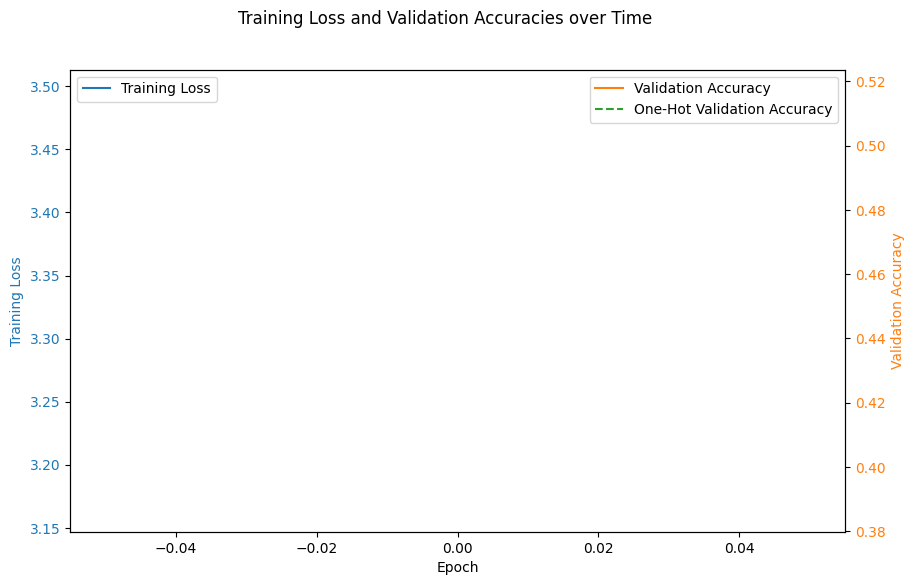

In [59]:
def plot_loss_and_accuracy(train_losses, eval_accuracies, eval_one_hot_accuracies):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Training Loss on the left y-axis
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss', color='tab:blue')
    ax1.plot(train_losses, label='Training Loss', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second y-axis for validation accuracies (standard and one-hot)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy', color='tab:orange')

    # Plot standard validation accuracy
    ax2.plot(eval_accuracies, label='Validation Accuracy', color='tab:orange', linestyle='-')
    
    # Plot one-hot validation accuracy
    ax2.plot(eval_one_hot_accuracies, label='One-Hot Validation Accuracy', color='tab:green', linestyle='--')
    
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Add titles and legends
    fig.suptitle('Training Loss and Validation Accuracies over Time')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Save the figure
    file_path = "/kaggle/working/training_loss_and_accuracy_plot_128_1.png"
    plt.savefig(file_path)
    print(f"Plot saved to {file_path}")

    # Display the plot
    plt.show()

# Example of calling the updated plot function with all three metrics
plot_loss_and_accuracy(train_losses, eval_accuracies, eval_one_hot_accuracies)


In [ ]:
def demonstrate_compression(autoencoder1, autoencoder2, text):
    autoencoder1.eval()
    autoencoder2.eval()
    
    with torch.no_grad():
        # Tokenize and prepare input
        tokenized = tokenizer.encode(text)
        print(seq_len)
        if len(tokenized) < seq_len:
            tokenized += [tokenizer.original_char_to_idx[tokenizer.pad_token]] * (seq_len - len(tokenized))  # Pad to seq_len using <PAD>
        input_seq = torch.tensor(tokenized[:seq_len], dtype=torch.long).unsqueeze(0).to(device)
        print(input_seq.shape)
        

        # Step 1: Compress using autoencoder1 (Encoder)
        compressed_output = autoencoder1(input_seq)

        # Step 2: Take argmax over the output to get discrete token indices
        compressed_indices = torch.argmax(compressed_output, dim=-1)  # Shape: (batch_size, output_length)
        compressed_chars = ''.join([tokenizer.original_idx_to_char[idx.item()] for idx in compressed_indices[0]])

        # Step 3: Convert argmax indices back to embeddings or one-hot vectors (optional based on your decoder)
        # Assuming we can pass the indices directly if decoder is equipped to handle them:
        compressed_indices_one_hot = F.one_hot(compressed_indices, num_classes=autoencoder1.output_vocab_size).float()
        # print(compressed_indices_one_hot)

        # Step 4: Decompress using autoencoder2 (Decoder), passing the argmax indices in one-hot format or directly
        reconstructed_output = autoencoder2(compressed_indices_one_hot)

        # Step 5: Take argmax on the decoder output to get the predicted token indices
        clamped_output = torch.clamp(torch.argmax(reconstructed_output, dim=-1), 0, tokenizer.original_vocab_size - 1)

        # Convert indices back to characters
        reconstructed_chars = ''.join([
            tokenizer.original_idx_to_char[idx.item()] if idx.item() != tokenizer.original_char_to_idx[tokenizer.pad_token] else tokenizer.pad_token 
            for idx in clamped_output[0]
        ])

        return compressed_chars, reconstructed_chars

# Example usage
#input_text = tokenizer.decode(progressive_train_sequences[62])
input_text = "hello world "
compressed, reconstructed = demonstrate_compression(encoder, decoder, input_text)
print(f"Original: {input_text}")
print(f"Compressed ({len(compressed)} chars): {compressed}")
print(f"Reconstructed: {reconstructed}")

In [ ]:
# Specify the file paths to save your models
encoder_path = "/kaggle/working/encoder_model_128_9.pth"
decoder_path = "/kaggle/working/decoder_model_128_9.pth"

# Save the encoder model
torch.save(encoder.state_dict(), encoder_path)
print(f"Encoder model saved to {encoder_path}")

# Save the decoder model
torch.save(decoder.state_dict(), decoder_path)
print(f"Decoder model saved to {decoder_path}")


In [ ]:
# Load the encoder model safely
encoder.load_state_dict(torch.load(encoder_path, weights_only=True))

# Load the decoder model safely
decoder.load_state_dict(torch.load(decoder_path, weights_only=True))

In [ ]:
def demonstrate_compression(autoencoder1, autoencoder2, text):
    autoencoder1.eval()
    autoencoder2.eval()
    
    with torch.no_grad():
        # Tokenize and prepare input
        tokenized = tokenizer.encode(text)
        print(seq_len)
        if len(tokenized) < seq_len:
            tokenized += [tokenizer.original_char_to_idx[tokenizer.pad_token]] * (seq_len - len(tokenized))  # Pad to seq_len using <PAD>
        input_seq = torch.tensor(tokenized[:seq_len], dtype=torch.long).unsqueeze(0).to(device)
        print(input_seq.shape)
        

        # Step 1: Compress using autoencoder1 (Encoder)
        compressed_output = autoencoder1(input_seq)

        # Step 2: Take argmax over the output to get discrete token indices
        compressed_indices = torch.argmax(compressed_output, dim=-1)  # Shape: (batch_size, output_length)
        compressed_chars = ''.join([tokenizer.original_idx_to_char[idx.item()] for idx in compressed_indices[0]])

        # Step 3: Convert argmax indices back to embeddings or one-hot vectors (optional based on your decoder)
        # Assuming we can pass the indices directly if decoder is equipped to handle them:
        compressed_indices_one_hot = F.one_hot(compressed_indices, num_classes=autoencoder1.output_vocab_size).float()
        # print(compressed_indices_one_hot)

        # Step 4: Decompress using autoencoder2 (Decoder), passing the argmax indices in one-hot format or directly
        reconstructed_output = autoencoder2(compressed_indices_one_hot)

        # Step 5: Take argmax on the decoder output to get the predicted token indices
        clamped_output = torch.clamp(torch.argmax(reconstructed_output, dim=-1), 0, tokenizer.original_vocab_size - 1)

        # Convert indices back to characters
        reconstructed_chars = ''.join([
            tokenizer.original_idx_to_char[idx.item()] if idx.item() != tokenizer.original_char_to_idx[tokenizer.pad_token] else tokenizer.pad_token 
            for idx in clamped_output[0]
        ])

        return compressed_chars, reconstructed_chars

# Example usage
#input_text = tokenizer.decode(progressive_train_sequences[62])
input_text = "hello world "
compressed, reconstructed = demonstrate_compression(encoder, decoder, input_text)
print(f"Original: {input_text}")
print(f"Compressed ({len(compressed)} chars): {compressed}")
print(f"Reconstructed: {reconstructed}")